# 网页浏览行为关联规则挖掘
## 数据集介绍
[Anonymous Microsoft Web Data](http://archive.ics.uci.edu/ml/datasets/Anonymous+Microsoft+Web+Data) 
该数据集记录了 38000 名随机选择的匿名用户对 www.microsoft.com 的使用情况<br>
网站的一个域称为vroot<br>
### 数据示例
1. 'A,1277,1,"NetShow for PowerPoint","/stream"’<br>
A表示是属性行，1277是该域的ID，netshow for powerpoint是title，/stream是URL;<br>
2. C,"10164",10164<br>
   V,1123,1<br>
   V,1009,1<br>
   V,1052,1<br>
C表示是案例行，10164是一个使用者的案例的ID，V表示是这个案例的vote行；1123，1009,1052是某个使用者拜访的域属性ID，即表示用户10164拜访的域有1123,1009,1052<br>

## 数据预处理: 清洗数据，处理缺失值，提取用户浏览记录。
根据数据集介绍可知本数据集不存在缺失值<br>
数据预处理过程如下，其中attr存储了各Vroot的属性，user存储了每个用户访问记录，userID存储了每个用户对应的ID，vis字典存储了各Vroot被访问的次数

In [1]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder#编码
from mlxtend.frequent_patterns import apriori#Apriori
from mlxtend.frequent_patterns import association_rules#导入关联规则包

fpath = "./anonymous-msweb.data"
attr = {}
vis={}
user = []
usrID = []
fp  =  open(fpath,"r")
fp.seek(0,0)
subline=""
canread = True
while  True:
    if canread:
        line  =  fp.readline()
    else:
        line = subline
    x = line.strip().split(',')
    if x[0] == 'A':#属性行
        lattr = []
        attr[x[1]]=x[3]
        vis[x[1]] = 0#将访问次数初始化为0

    elif x[0]=='C':
        luser=[]
        usrID.append(x[2])
        while True:
            subline = fp.readline()
            subx = subline.strip().split(',')
            if subx[0] == 'V':
                luser.append(subx[1])
                vis[subx[1]]+=1
                #print(luser)
            else:
                user.append(luser)
     
                canread = False
                break
    # If line is empty then end of file reached
    if  not  line  :
        break;

fp.close()
print("data has finished")

data has finished


## 数据探索性分析
分析最常被访问的页面、页面访问量分布


In [2]:
max_p = max(zip(vis.values(), vis.keys()))
print("最常被访问的页面是%s,被访问次数是%d"%(attr[max_p[1]],max_p[0]))
dc = pd.DataFrame.from_dict(vis, orient='index',columns=['num'])
dc = dc.reset_index().rename(columns = {'index':'id'})
print("对访问次数的可能取值及频数分析如下：")
print(dc['num'].value_counts())
des = dc['num'].describe()
des_min = des['min']
des_q1 = des['25%']
des_median = des['50%']
des_q3 = des['75%']
des_max = des['max']
print("页面被访问次数的最小值为{},第一四分位数为{},中位数为{},第三四分位数为{},最大值为{}".format(des_min,des_q1,des_median,des_q3,des_max))

最常被访问的页面是"Free Downloads",被访问次数是10836
对访问次数的可能取值及频数分析如下：
1       21
3       12
4       11
2       10
0        9
        ..
548      1
521      1
8463     1
1500     1
291      1
Name: num, Length: 168, dtype: int64
页面被访问次数的最小值为0.0,第一四分位数为8.25,中位数为43.5,第三四分位数为182.5,最大值为10836.0


## 关联规则挖掘和结果评估: 
使用Apriori算法，根据用户浏览记录计算频繁项集和关联规则。使用mlxtend包中的association_rules方法，设置支持度阈值和置信度阈值后，会默认计算关联规则的支持度、置信度和提升度。

In [3]:

print("start analysis")
te = TransactionEncoder()
#进行 one-hot 编码

tf = te.fit_transform(user)
df = pd.DataFrame(tf,columns=te.columns_)
freq = apriori(df, min_support=0.05, use_colnames=True).sort_values(by='support', ascending=False)
print("当阈值设置为0.05时的频繁项集如下：")
print(freq)

start analysis
当阈值设置为0.05时的频繁项集如下：
     support      itemsets
3   0.331265        (1008)
9   0.286845        (1034)
2   0.258720        (1004)
6   0.162942        (1018)
18  0.160802  (1008, 1034)
5   0.156155        (1017)
4   0.141481        (1009)
0   0.136070        (1001)
8   0.098438        (1026)
1   0.090734        (1003)
15  0.077925  (1008, 1009)
17  0.073064  (1008, 1018)
7   0.064902        (1025)
16  0.061233  (1008, 1017)
13  0.060438  (1008, 1004)
12  0.059430  (1001, 1018)
11  0.055211  (1001, 1003)
10  0.054752        (1035)
14  0.053285  (1004, 1034)


In [4]:
rules =  association_rules(freq,metric ='confidence',min_threshold = 0.4)
rules = rules.drop(['leverage','conviction'],axis = 1)
print("支持度阈值为0.03，置信度阈值设为0.4时，关联规则及其支持度、置信度和提升度如下：")
print(rules)

支持度阈值为0.03，置信度阈值设为0.4时，关联规则及其支持度、置信度和提升度如下：
  antecedents consequents  antecedent support  consequent support   support  \
0      (1008)      (1034)            0.331265            0.286845  0.160802   
1      (1034)      (1008)            0.286845            0.331265  0.160802   
2      (1009)      (1008)            0.141481            0.331265  0.077925   
3      (1018)      (1008)            0.162942            0.331265  0.073064   
4      (1001)      (1018)            0.136070            0.162942  0.059430   
5      (1001)      (1003)            0.136070            0.090734  0.055211   
6      (1003)      (1001)            0.090734            0.136070  0.055211   

   confidence      lift  zhangs_metric  
0    0.485419  1.692267       0.611717  
1    0.560588  1.692267       0.573616  
2    0.550778  1.662652       0.464231  
3    0.448405  1.353616       0.312091  
4    0.436756  2.680435       0.725668  
5    0.405752  4.471879       0.898662  
6    0.608491  4.471879       0.8538

In [5]:
for index, row in rules.iterrows():
    #print(row)
    t1 = next(iter(row['antecedents']))
    t2 = next(iter(row['consequents']))
    print("%s ⇒ %s (支持度是 = %f, 置信度是 = %f )"%(attr[t1],attr[t2],row['support'],row['confidence']))

"Free Downloads" ⇒ "Internet Explorer" (支持度是 = 0.160802, 置信度是 = 0.485419 )
"Internet Explorer" ⇒ "Free Downloads" (支持度是 = 0.160802, 置信度是 = 0.560588 )
"Windows Family of OSs" ⇒ "Free Downloads" (支持度是 = 0.077925, 置信度是 = 0.550778 )
"isapi" ⇒ "Free Downloads" (支持度是 = 0.073064, 置信度是 = 0.448405 )
"Support Desktop" ⇒ "isapi" (支持度是 = 0.059430, 置信度是 = 0.436756 )
"Support Desktop" ⇒ "Knowledge Base" (支持度是 = 0.055211, 置信度是 = 0.405752 )
"Knowledge Base" ⇒ "Support Desktop" (支持度是 = 0.055211, 置信度是 = 0.608491 )


以上列出的为支持度阈值设置为0.03，置信度阈值设置为0.4时的强关联规则

## 规则评价
这里使用提升度Lift和全置信度allconf。提升度Lift已经在上面的计算过程中展示了，下面将计算全置信度：

In [6]:
def allconf(x):
    return x.support/max(x['antecedent support'],x['consequent support'])
allconf_list = []
for index, row in rules.iterrows():
    allconf_list.append(allconf(row))
rules['allconf'] = allconf_list
rules.drop(['antecedent support','consequent support'],axis=1,inplace=False)

,antecedents,consequents,support,confidence,lift,zhangs_metric,allconf
0,(1008),(1034),0.160802,0.485419,1.692267,0.611717,0.485419
1,(1034),(1008),0.160802,0.560588,1.692267,0.573616,0.485419
2,(1009),(1008),0.077925,0.550778,1.662652,0.464231,0.235234
3,(1018),(1008),0.073064,0.448405,1.353616,0.312091,0.220561
4,(1001),(1018),0.059430,0.436756,2.680435,0.725668,0.364728
5,(1001),(1003),0.055211,0.405752,4.471879,0.898662,0.405752
6,(1003),(1001),0.055211,0.608491,4.471879,0.853854,0.405752


## 结果分析与应用
分析得到的关联规则，为网站提供导航结构优化建议，以提升用户体验<br>
可以将（Internet Explorer，/ie）的Vroot和（Free Downloads,"/msdownload"）相互关联；<br>
将（Support Desktop，/support）和（Knowledge Base，/kb）相互关联；<br>
实现以下导航：（Support Desktop，/support）=>（isapi，/isapi）=>（Free Downloads，/msdownload）<br>
都将提升用户体验

## 可视化
### 置信度-支持度散点图

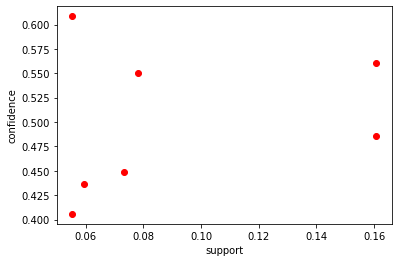

In [7]:
from matplotlib import pyplot as plt
plt.xlabel('support')
plt.ylabel('confidence')
for i in range(rules.shape[0]):
    plt.scatter(rules.support[i],rules.confidence[i],c='r')

### 支持度-提升度散点图

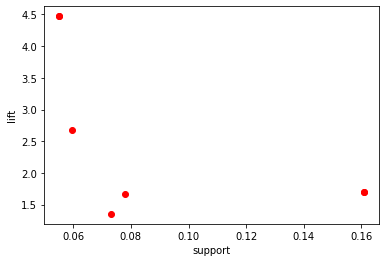

In [8]:
plt.xlabel('support')
plt.ylabel('lift')
for i in range(rules.shape[0]):
    plt.scatter(rules.support[i],rules.lift[i],c='r')